In [3]:
# ACKNOWLEDGEMENT: highly adpated from martinarjovsky/WassersteinGAN!

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.init
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import seaborn as sns
from torch.autograd import Variable
import Model.mlp as mlp
import Model.dcgan as dcgan

In [4]:
workers=4
batchSize=64
imageSize=32
nc=1
nz=100             # size of the latent z vector
ngh=128          # size of hidden layer of G
ndh=128           # size of hidden layer of D 
nker=16
kerdim=4
niter=60          # number of epochs to train for
lrD=0.00008       # learning rate for Critic, default=0.00005
lrG=0.00008      # learning rate for Generator, default=0.00005
cuda=True         # enables cuda
ngpu=6            # number of GPUs to use 
clamp_lower=-0.01
clamp_upper=0.01
diters=5        # number of D iters per each G iter
before_gen=25     # D "burn in part" 
mlp_G=True
mlp_D=True
CNN=True
n_extra_layers=0
noBN=True         # disable the batch norm
dirname="experiment"
dataroot="MNIST"
dropout=True
randomseed=10000

In [5]:



os.system('mkdir {0}'.format(dirname))
print("Random Seed: ", randomseed)
random.seed(randomseed)
torch.manual_seed(randomseed)

cudnn.benchmark = True


if torch.cuda.is_available() and not cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")
dataset = dset.MNIST(root=dataroot, download=False,
                           transform=transforms.Compose([
                               transforms.Scale(imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                     ])
        )
print(dataset)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=workers)

Random Seed:  10000


In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        #m.weight.data.normal_(0.0, clamp_upper-clamp_lower)
        nn.init.xavier_uniform(m.weight)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        nn.init.xavier_uniform(m.weight)
if CNN:
    netG=dcgan.DCGAN_G(imageSize, nz, nc, ngh, ngpu, n_extra_layers, dropout)
    netG.apply(weights_init)
    print(netG)
    
    netD=dcgan.DCGAN_D(imageSize, nz, nc, ndh, ngpu, n_extra_layers)
    netD.apply(weights_init)
    print(netD)
else: 
    netG = mlp.MLP_G(imageSize, nc, nz, ngh, ngpu)
    netG.apply(weights_init)
    print(netG)

    netD = mlp.MLP_D(imageSize, nc, ndh, ngpu)
    netD.apply(weights_init)
    print(netD)

DCGAN_G (
  (main): Sequential (
    (dd): Dropout2d (p=0.5)
    (initial.100-512.convt): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial.512.relu): ReLU (inplace)
    (pyramid.512-256.convt): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.256.relu): ReLU (inplace)
    (pyramid.256-128.convt): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.128.relu): ReLU (inplace)
    (final.128-1.convt): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (final.1.tanh): Tanh ()
  )
)
DCGAN_D (
  (main): Sequential (
    (initial.conv.1-128): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (initial.relu.128): LeakyReLU

In [7]:
input_x = torch.FloatTensor(batchSize, nc, imageSize, imageSize)
input_z = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_z = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
one = torch.FloatTensor([1.0])
mone = one * -1

if cuda:
    netD.cuda()
    netG.cuda()
    input_x = input_x.cuda()
    one, mone = one.cuda(), mone.cuda()
    input_z, fixed_z = input_z.cuda(), fixed_z.cuda()
    

optimizerD = optim.RMSprop(netD.parameters(), lr = lrD)
optimizerG = optim.RMSprop(netG.parameters(), lr = lrG)

In [ ]:
gen_iterations = 0
LossD = []
for epoch in range(niter):
    data_iter = iter(dataloader)
    i = 0
    while i < len(dataloader):
        ############################
        # (1) Update D network
        ############################
        for p in netD.parameters():      # reset requires_grad
            p.requires_grad = True       # they are set to False below in netG update
            # train the discriminator Diters times
        if gen_iterations < before_gen or gen_iterations % 300 == 0:
            Diters = 100
        else:
            Diters = diters
        j = 0
        while j < Diters and i < len(dataloader):
            j += 1
            # clamp parameters to a cube
            for p in netD.parameters():
                pass
                p.data.clamp_(clamp_lower, clamp_upper)
            data = data_iter.next()
            i += 1
            # train with real
            real_cpu, _ = data
            netD.zero_grad()
            batch_size = real_cpu.size(0)                
            if cuda:
                real_cpu = real_cpu.cuda()
            input_x.resize_as_(real_cpu).copy_(real_cpu)
            inputv = Variable(input_x)
            # RMSprop minimize errD_real - errD_fake, but due to equation here(https://cloud.githubusercontent.com/assets/5272722/22793339/9210a6ea-eebd-11e6-8f3d-aeae2827b955.png)
            # it maximize W estimate simultaneously, which is -Loss_D.  
            errD_real = netD(inputv)
            errD_real.backward(one)
            # train with fake
            input_z.resize_(batchSize, nz,1,1).normal_(0, 1)
            if dropout:
                input_zv = Variable(fixed_z, volatile = True) # totally freeze netG
            else:
                input_zv = Variable(input_z, volatile = True) # totally freeze netG
            fake = Variable(netG(input_zv).data)                
            inputv = fake
            errD_fake = netD(inputv)
            errD_fake.backward(mone)
            
            errD = errD_real - errD_fake
            optimizerD.step()
        ############################
        # (2) Update G network
        ###########################
        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        netG.zero_grad()
        # in case our last batch was the tail batch of the dataloader,
        # make sure we feed a full batch of noise
        input_z.resize_(batchSize, nz,1,1).normal_(0, 1)
        if dropout:
            input_zv = Variable(fixed_z)
        else:
            input_zv = Variable(input_z)
        fake = netG(input_zv)
        errG = netD(fake)
        errG.backward(one)
        optimizerG.step()
        gen_iterations += 1
        print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake: %f'
            % (epoch, niter, i, len(dataloader), gen_iterations,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))
        if gen_iterations % 500 == 0:
            real_cpu = real_cpu.mul(0.5).add(0.5)
            vutils.save_image(real_cpu, '{0}/real_samples.png'.format(dirname))
            fake = netG(Variable(fixed_z, volatile=True))
            fake.data = fake.data.mul(0.5).add(0.5)
            vutils.save_image(fake.data, '{0}/fake_samples_{1}.png'.format(dirname, gen_iterations))
        LossD.append(errD.data[0])
        

    # do checkpointing
    torch.save(netG.state_dict(), '{0}/netG_epoch_{1}.pth'.format(dirname, epoch))
    torch.save(netD.state_dict(), '{0}/netD_epoch_{1}.pth'.format(dirname, epoch))


[0/60][100/938][1] Loss_D: -1.437391 Loss_G: 0.736418 Loss_D_real: -0.721462 Loss_D_fake: 0.715929
[0/60][200/938][2] Loss_D: -1.502725 Loss_G: 0.775950 Loss_D_real: -0.740874 Loss_D_fake: 0.761850
[0/60][300/938][3] Loss_D: -1.501144 Loss_G: 0.775081 Loss_D_real: -0.739559 Loss_D_fake: 0.761585
[0/60][400/938][4] Loss_D: -1.509541 Loss_G: 0.776003 Loss_D_real: -0.745614 Loss_D_fake: 0.763927
[0/60][500/938][5] Loss_D: -1.500487 Loss_G: 0.763204 Loss_D_real: -0.750233 Loss_D_fake: 0.750254
[0/60][600/938][6] Loss_D: -1.504219 Loss_G: 0.767476 Loss_D_real: -0.748736 Loss_D_fake: 0.755484
[0/60][700/938][7] Loss_D: -1.500933 Loss_G: 0.764289 Loss_D_real: -0.749895 Loss_D_fake: 0.751038
[0/60][800/938][8] Loss_D: -1.497670 Loss_G: 0.760250 Loss_D_real: -0.749220 Loss_D_fake: 0.748450
[0/60][900/938][9] Loss_D: -1.492891 Loss_G: 0.758190 Loss_D_real: -0.748211 Loss_D_fake: 0.744680
[0/60][938/938][10] Loss_D: -1.474421 Loss_G: 0.739179 Loss_D_real: -0.748854 Loss_D_fake: 0.725567
[1/60][10

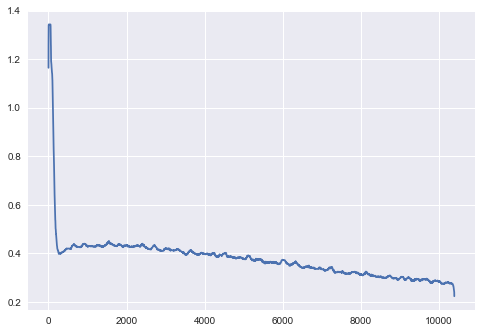

In [7]:
import scipy.signal
import seaborn
import matplotlib.pyplot as plt
neg_LossD = -np.array(LossD, dtype=np.float64)
med_filtered_loss = scipy.signal.medfilt(neg_LossD, 101)

plt.plot(range(len(med_filtered_loss)), med_filtered_loss)
plt.show()